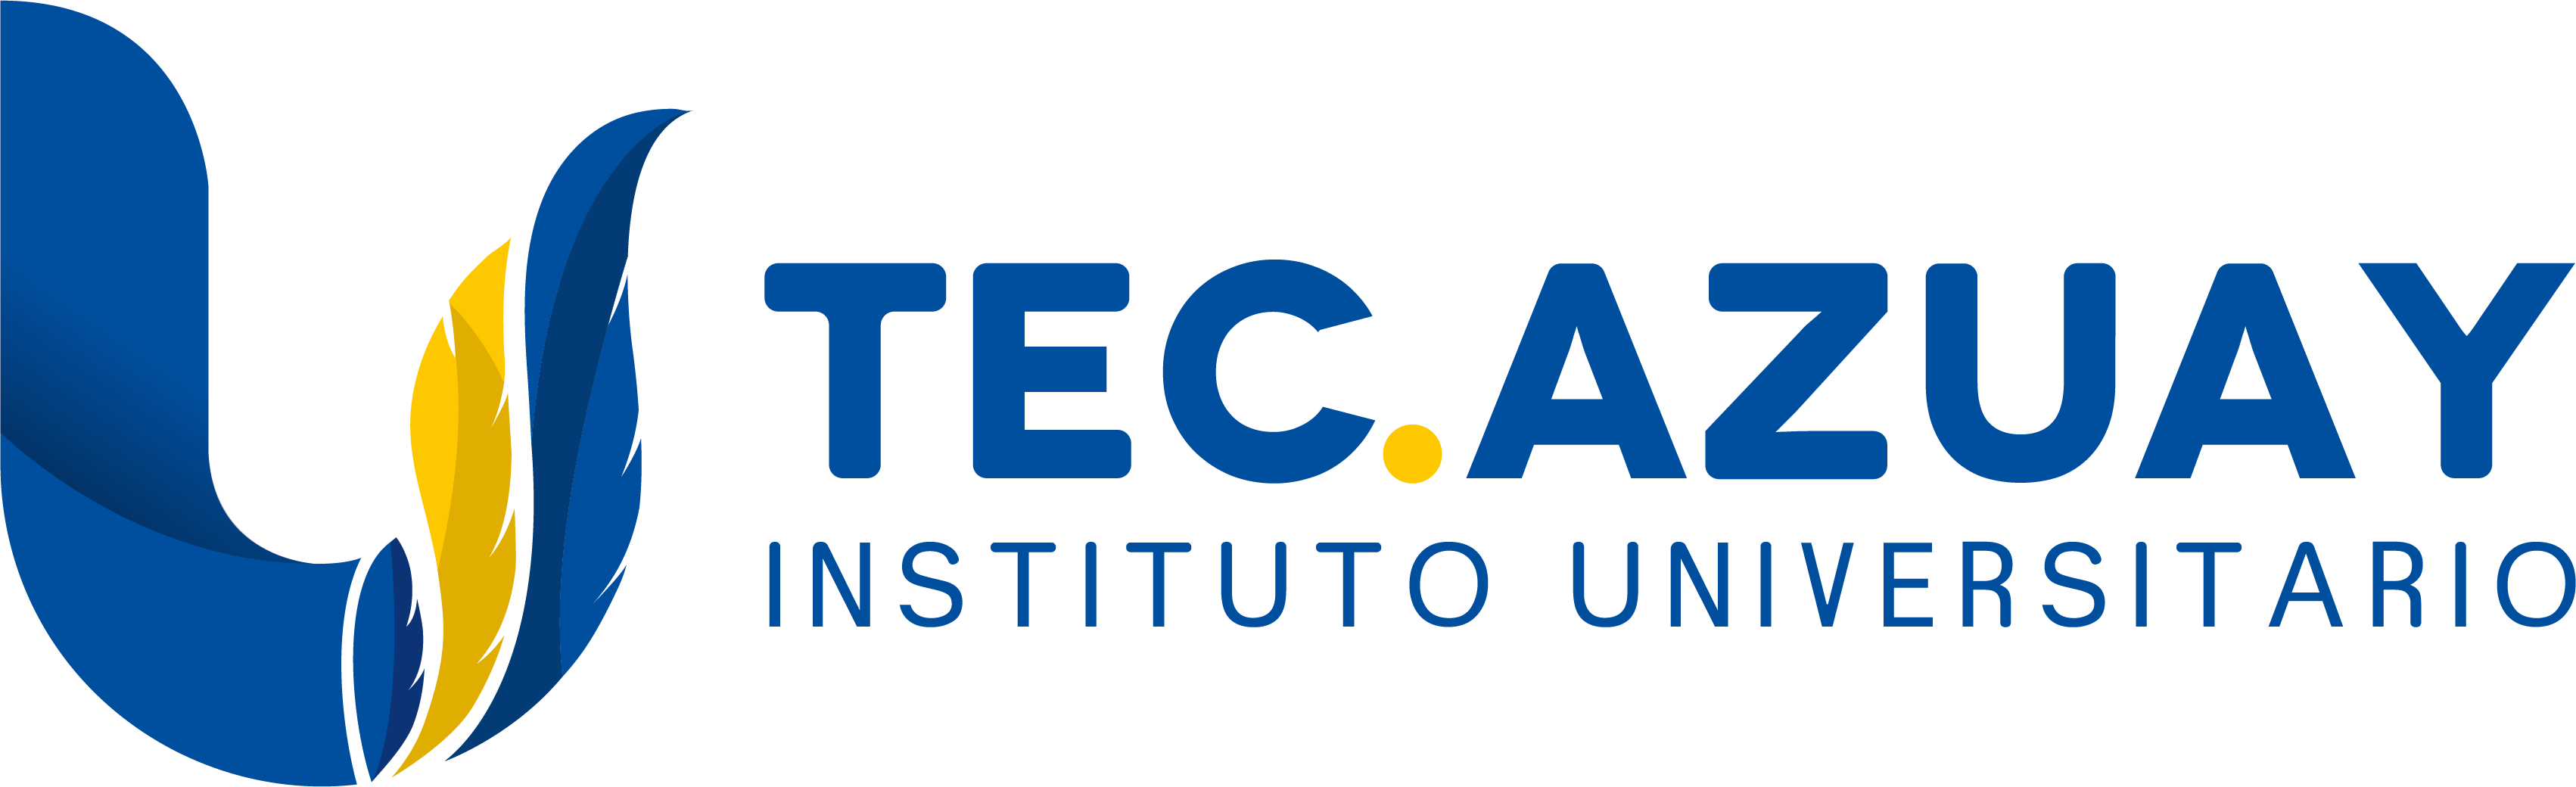

**Nombre:** Victor Cabrera

**Docente:** Ing.Veronica Chimbo

**Asignatura:** Marcos de referencia para big data

# Caso práctico de Analítica Escalable (Ejercicios) #

En este notebook, se van a realizar los ejercicios del módulo. En lugar de tener contenido teórico y descripciones, se dejarán únicamente las celdas de código necesarias para su ejecución.

Para completar los ejercicios, hay que codificar y ejecutar la solución en las celdas que se encuentran justo debajo de los enunciados de los ejercicios.

Una vez se haya terminado, en el menú de la izquiera, a la hora de seleccionar el notebook, si se le hace click a la flecha que se encuentra en la derecha, se puede exportar al notebook. Hay que exportarlo en formato DBC (Databricks Notebook) como en HTML.

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=0ae446cadbebed8296042822aa3fb61d90824b8a873087b619f771b4b0d4c142
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder.appName("CardiacDataAnalysis").getOrCreate()

# Acceder a la versión de Spark
print(spark.version)


3.5.1


Los ejercicios consistirán en añadir nuevas funcionalidades, o ejecutar nuevo código, sobre el Notebook que contiene toda la teoría vista en el módulo. Por ello, gran parte del código que se encuentra dentro del notebook de contenido teórico se encontrará aquí de nuevo, pero se pedirá nuevo código.

## Importando los datos ##

In [3]:
import pandas as pd

# Leer el archivo CSV
df = pd.read_csv('/content/heart.csv')

# Mostrar las primeras filas del dataframe
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
def score_to_string(score):
  if score < 5:
    return "Bad"
  elif score < 7:
    return "Normal"
  elif score < 9:
    return "Good"
  elif score < 10:
    return "Excellent"
  else:
    return "Perfect"

def score_to_evaluation(score_string):
  score_dict = {
    "Bad": 0,
    "Normal": 1,
    "Good": 2,
    "Excellent": 3,
    "Perfect": 4
  }
  return score_dict.get(score_string, None)

## DataFrames en Spark: SparkSQL. ##

In [5]:
df_spark_sql = spark.read.format("csv")\
         .option("header", "true")\
         .option("inferSchema", "true")\
         .load("/content/heart.csv")

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType

score_string_udf = udf(score_to_string, StringType())
score_evaluation_udf = udf(score_to_evaluation, IntegerType())

In [7]:
df_spark_sql.printSchema()


root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [8]:
# Aplicar las UDFs en la coluumna chol
df_spark_sql = df_spark_sql.withColumn('score_string', score_string_udf(df_spark_sql["chol"]))
df_spark_sql = df_spark_sql.withColumn('score_evaluation', score_evaluation_udf(df_spark_sql["score_string"]))


In [9]:
# Definir la función para redondear el valor
def round_oldpeak(oldpeak):
    return int(round(oldpeak)) if oldpeak is not None else None

# Convertir la función a una UDF
round_oldpeak_udf = udf(round_oldpeak, IntegerType())

# Aplicar la UDF a la columna 'oldpeak'
df_spark_sql = df_spark_sql.withColumn("rounded_oldpeak", round_oldpeak_udf(df_spark_sql["oldpeak"]))

### Ejercicio 1: Crear un bucle que muestre todas las columnas del DataFrame, junto con sus tipos. También puedes pintar el esquema del Dataframe. ###

In [10]:
# Escribir aquí el ejericicio
print("Primero imprimimos el esquema:")
print(df_spark_sql.printSchema())
print("Ahora hacemos el bucle que muestra las columnas y tipos del dataFrame")
for name, dtype in df_spark_sql.dtypes:
  print(name, " --> ",dtype)

Primero imprimimos el esquema:
root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- score_string: string (nullable = true)
 |-- score_evaluation: integer (nullable = true)
 |-- rounded_oldpeak: integer (nullable = true)

None
Ahora hacemos el bucle que muestra las columnas y tipos del dataFrame
age  -->  int
sex  -->  int
cp  -->  int
trestbps  -->  int
chol  -->  int
fbs  -->  int
restecg  -->  int
thalach  -->  int
exang  -->  int
oldpeak  -->  double
slope  -->  int
ca  -->  int
thal  -->  int
target  -->  i

### Ejercicio 2: Realizar un muestreo de 10 valores únicos de nombres de hoteles. Ordénalos alfanuméricamente de forma ascendente (primero los números 0-9, después A-Z). ###

In [11]:
# Escribir aquí el ejercicio
df_spark_sql.select('target').distinct().limit(10).orderBy("target").show()

+------+
|target|
+------+
|     0|
|     1|
+------+



### Ejercicio 3: Transformamos la columna *oldpeak* al tipo Float.

In [12]:
# Transformación de la columna sin utilizar UDF.
from pyspark.sql.types import FloatType

# Convertir la columna 'oldpeak' a FloatType
df_new_aux = df_spark_sql.withColumn("oldpeak", df_spark_sql["oldpeak"].cast(FloatType()))

# Actualizar el DataFrame original
df_spark_sql = df_new_aux

# Comprobamos que ha cambiado
print('  ----  Comprobamos que ha cambiado ------ ')
df_spark_sql.printSchema()

  ----  Comprobamos que ha cambiado ------ 
root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: float (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- score_string: string (nullable = true)
 |-- score_evaluation: integer (nullable = true)
 |-- rounded_oldpeak: integer (nullable = true)



In [13]:
splits = df_spark_sql.randomSplit([0.67, 0.33])
df_spark_sql_train = splits[0].dropna()
df_spark_sql_test = splits[1].dropna()
print(df_spark_sql_train.count())
print(df_spark_sql_test.count())

210
93


### Ejercicio 4: # 1. ¿Cuántas personas tienen una `thalach` (máxima frecuencia cardíaca alcanzada) por encima de 150?

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [15]:
# Escribir aquí el ejercicio
thalach_above_150 = df[df["thalach"] > 150].shape[0]
print(f"Personas con thalach > 150: {thalach_above_150}")

Personas con thalach > 150: 164


### Ejercicio 5: Obtener el chol con mayor puntuación media, descartando todos los que tengan una puntuación por encima de Good. (Utilizar el dataset de Train) ###

In [16]:
# Escribir aquí el ejercicio
# Agrupar por 'cp' y calcular el promedio de 'chol'
df_puntuacion = df.groupby('cp')['chol'].mean().reset_index()

# Renombrar la columna de promedio
df_puntuacion.rename(columns={'chol': 'avg(chol)'}, inplace=True)

# Ordenar por 'avg(chol)' en orden descendente y mostrar los 10 primeros resultados
df_puntuacion_sorted = df_puntuacion.sort_values(by='avg(chol)', ascending=False)

top_10 = df_puntuacion_sorted.head(10)

print("Top 10 grupos con mayor promedio de colesterol:")
print(top_10)

Top 10 grupos con mayor promedio de colesterol:
   cp   avg(chol)
0   0  250.132867
1   1  244.780000
2   2  243.172414
3   3  237.130435


# Machine Learning en Apache Spark: Spark MLLib y Spark ML #

## Clasificación Supervisada: Árboles de decisión ##

### Ejercicio 6.1: Volver a observar todas las columnas del dataframe, para identificar las que sean categóricas. ###

In [17]:
# Escribir aquí el ejercicio
print("   ---------- Primero imprimimos el esquema: -----------")
print(df_spark_sql.printSchema())
print("   ---------- Despues imprimimos algunos datos: -----------")
df_spark_sql.select('*').limit(100).show()

   ---------- Primero imprimimos el esquema: -----------
root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: float (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- score_string: string (nullable = true)
 |-- score_evaluation: integer (nullable = true)
 |-- rounded_oldpeak: integer (nullable = true)

None
   ---------- Despues imprimimos algunos datos: -----------
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+------------+----------------+---------------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal

### Ejercicio 6.2: Eliminar, de los dataframes df_spark_sql_train y df_spark_sql test, las variables 'Hotel_Address', 'Hotel_Name', 'Tags', 'Positive Review', 'Negative_Review' y 'score_string'. Llamarlos: df_DT_train y df_DT_test. ###

En nuestro caso no eliminaremos ninguna de las columnas descritas ya que todas parecen relevantes para el análisis de datos y la predicción del riesgo cardiovascular.

In [18]:
# Escribir aquí el ejercicio
df_DT_train = df_spark_sql_train.drop('Hotel_Address', 'Hotel_Name', 'Tags', 'Positive_Review', 'Negative_Review', 'score_string')
print("   ---------- Comprobamos que se han eliminado las columnas de df_DT_train -----------")
print(df_DT_train.printSchema())
df_DT_test = df_spark_sql_test.drop('Hotel_Address', 'Hotel_Name', 'Tags', 'Positive_Review', 'Negative_Review', 'score_string')
print("   ---------- Comprobamos que se han eliminado las columnas de df_DT_test -----------")
print(df_DT_test.printSchema())

   ---------- Comprobamos que se han eliminado las columnas de df_DT_train -----------
root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: float (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- score_evaluation: integer (nullable = true)
 |-- rounded_oldpeak: integer (nullable = true)

None
   ---------- Comprobamos que se han eliminado las columnas de df_DT_test -----------
root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-

### Ejercicio 7: Para cada columa restante que sea String (' cp, fbs, restecg, slope, thal'), aplicar un StringIndexer(), devolviendo como resultado la misma columna, pero con su nombre acabando en _index. Sobreescribir ambos dataframes.  ###

In [19]:
# Escribir aquí el ejercicio
from pyspark.ml.feature import StringIndexer

print("   ---------- Definimos un indexer para cada columna categórica -----------")

# Definir indexers para las columnas categóricas
indexerCP = StringIndexer(inputCol="cp", outputCol="cp_index")
indexerFBS = StringIndexer(inputCol="fbs", outputCol="fbs_index")
indexerRestECG = StringIndexer(inputCol="restecg", outputCol="restecg_index")
indexerSlope = StringIndexer(inputCol="slope", outputCol="slope_index")
indexerThal = StringIndexer(inputCol="thal", outputCol="thal_index")

print("   ---------- Ejecutamos los indexers sobre ambos DataFrames -----------")

# Aplicar los indexers a df_DT_train
df_DT_train = indexerCP.fit(df_DT_train).transform(df_DT_train)
df_DT_train = indexerFBS.fit(df_DT_train).transform(df_DT_train)
df_DT_train = indexerRestECG.fit(df_DT_train).transform(df_DT_train)
df_DT_train = indexerSlope.fit(df_DT_train).transform(df_DT_train)
df_DT_train = indexerThal.fit(df_DT_train).transform(df_DT_train)

# Aplicar los indexers a df_DT_test
df_DT_test = indexerCP.fit(df_DT_test).transform(df_DT_test)
df_DT_test = indexerFBS.fit(df_DT_test).transform(df_DT_test)
df_DT_test = indexerRestECG.fit(df_DT_test).transform(df_DT_test)
df_DT_test = indexerSlope.fit(df_DT_test).transform(df_DT_test)
df_DT_test = indexerThal.fit(df_DT_test).transform(df_DT_test)

print("   ---------- Comprobamos que se han creado las columnas en df_DT_train -----------")
df_DT_train.select('cp', 'cp_index', 'fbs', 'fbs_index', 'restecg', 'restecg_index', 'slope', 'slope_index', 'thal', 'thal_index').limit(100).show()

print("   ---------- Comprobamos que se han creado las columnas en df_DT_test -----------")
df_DT_test.select('cp', 'cp_index', 'fbs', 'fbs_index', 'restecg', 'restecg_index', 'slope', 'slope_index', 'thal', 'thal_index').limit(100).show()


   ---------- Definimos un indexer para cada columna categórica -----------
   ---------- Ejecutamos los indexers sobre ambos DataFrames -----------
   ---------- Comprobamos que se han creado las columnas en df_DT_train -----------
+---+--------+---+---------+-------+-------------+-----+-----------+----+----------+
| cp|cp_index|fbs|fbs_index|restecg|restecg_index|slope|slope_index|thal|thal_index|
+---+--------+---+---------+-------+-------------+-----+-----------+----+----------+
|  1|     2.0|  0|      0.0|      0|          1.0|    2|        1.0|   2|       0.0|
|  1|     2.0|  0|      0.0|      1|          0.0|    2|        1.0|   2|       0.0|
|  3|     3.0|  0|      0.0|      0|          1.0|    2|        1.0|   2|       0.0|
|  0|     0.0|  0|      0.0|      1|          0.0|    2|        1.0|   2|       0.0|
|  0|     0.0|  0|      0.0|      1|          0.0|    1|        0.0|   3|       1.0|
|  0|     0.0|  0|      0.0|      0|          1.0|    2|        1.0|   3|       1.0|
| 

### Ejercicio 8: Aplicar VectorAssembler() sobre las columnas que no son ni las dos anteriores, ni la columna 'score_evaluation', devolviendo una columna llamada 'features'. Llamar al resultado DT_vector_assembler. ###

In [20]:
# Escribir aquí el ejercicio
from pyspark.ml.feature import VectorAssembler

print("   ---------- Imprimimos el esquema para ver cuales son las columnas a utilizar -----------")
print(df_DT_train.printSchema())

DT_vector_assembler = VectorAssembler(
    inputCols=["Additional_Number_of_Scoring", "Average_Score", "Review_Total_Negative_Word_Counts", "Total_Number_of_Reviews", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given", "Reviewer_Score", "days_since_review", "Review_Date_index", "Reviewer_Nationality_index"],
    outputCol="features")

   ---------- Imprimimos el esquema para ver cuales son las columnas a utilizar -----------
root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: float (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- score_evaluation: integer (nullable = true)
 |-- rounded_oldpeak: integer (nullable = true)
 |-- cp_index: double (nullable = false)
 |-- fbs_index: double (nullable = false)
 |-- restecg_index: double (nullable = false)
 |-- slope_index: double (nullable = false)
 |-- thal_index: double (nullable = false)

None


### Ejercicio 9: Aplicar el transformador sobre ambos dataframes. ###

In [21]:
# Crear el VectorAssembler
assembler = VectorAssembler(
    inputCols=[
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'
    ],
    outputCol='features'  # Nombre de la nueva columna vectorial
)

print("   ---------- Aplicamos el VectorAssembler a los DataFrames -----------")


   ---------- Aplicamos el VectorAssembler a los DataFrames -----------


In [22]:
# Escribir aquí el ejercicio
from pyspark.ml.feature import VectorAssembler
# Aplicar el VectorAssembler a df_DT_train
df_DT_train_assembled = assembler.transform(df_DT_train)

# Aplicar el VectorAssembler a df_DT_test
df_DT_test_assembled = assembler.transform(df_DT_test)

print("   ---------- Vemos el DataFrame obtenido -----------")
df_DT_train_assembled.select("features").show(10, truncate=False)

print("   ---------- Vemos el DataFrame obtenido para df_DT_test -----------")
df_DT_test_assembled.select("features").show(10, truncate=False)

   ---------- Vemos el DataFrame obtenido -----------
+--------------------------------------------------------------------------+
|features                                                                  |
+--------------------------------------------------------------------------+
|[29.0,1.0,1.0,130.0,204.0,0.0,0.0,202.0,0.0,0.0,2.0,0.0,2.0]              |
|[34.0,0.0,1.0,118.0,210.0,0.0,1.0,192.0,0.0,0.699999988079071,2.0,0.0,2.0]|
|[34.0,1.0,3.0,118.0,182.0,0.0,0.0,174.0,0.0,0.0,2.0,0.0,2.0]              |
|[35.0,0.0,0.0,138.0,183.0,0.0,1.0,182.0,0.0,1.399999976158142,2.0,0.0,2.0]|
|[35.0,1.0,0.0,120.0,198.0,0.0,1.0,130.0,1.0,1.600000023841858,1.0,0.0,3.0]|
|[35.0,1.0,0.0,126.0,282.0,0.0,0.0,156.0,1.0,0.0,2.0,0.0,3.0]              |
|[37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0]              |
|[38.0,1.0,2.0,138.0,175.0,0.0,1.0,173.0,0.0,0.0,2.0,4.0,2.0]              |
|[38.0,1.0,3.0,120.0,231.0,0.0,1.0,182.0,1.0,3.799999952316284,1.0,0.0,3.0]|
|[39.0,0.0,2.0,94.0,19

### Ejercicio 10: Inicializar el modelo de árbol de decisión, entrenarlo y aplicarlo sobre los datos de test. ###
* Modelo: DecisionTreeClassifier:
  * Label: score_evaluation.
  * Features: features.
  * maxBins: 1000
  * maxDepth: 1

In [23]:
# Escribir aquí el ejercicio
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

# Crear el árbol de decisión
dt = DecisionTreeClassifier(labelCol="target", featuresCol="features", maxBins=1000, maxDepth=5)

# Crear el Pipeline
pipeline = Pipeline(stages=[dt])

# Entrenar el modelo con los datos de entrenamiento
model = pipeline.fit(df_DT_train_assembled)

print("   ---------- Aplicamos el modelo a los datos de TEST para obtener las previsiones y poder posteriormente evaluar el modelo -----------")

# Aplicar el modelo a los datos de prueba
predictions = model.transform(df_DT_test_assembled)

print("   ---------- Vemos resultados obtenidos -----------")
predictions.select("target", "features", "rawPrediction", "probability", "prediction").show(100, truncate=False)


   ---------- Aplicamos el modelo a los datos de TEST para obtener las previsiones y poder posteriormente evaluar el modelo -----------
   ---------- Vemos resultados obtenidos -----------
+------+----------------------------------------------------------------------------+-------------+----------------------------------------+----------+
|target|features                                                                    |rawPrediction|probability                             |prediction|
+------+----------------------------------------------------------------------------+-------------+----------------------------------------+----------+
|1     |[35.0,1.0,1.0,122.0,192.0,0.0,1.0,174.0,0.0,0.0,2.0,0.0,2.0]                |[8.0,83.0]   |[0.08791208791208792,0.9120879120879121]|1.0       |
|1     |[37.0,0.0,2.0,120.0,215.0,0.0,1.0,170.0,0.0,0.0,2.0,0.0,2.0]                |[8.0,83.0]   |[0.08791208791208792,0.9120879120879121]|1.0       |
|1     |[38.0,1.0,2.0,138.0,175.0,0.0,1.0,173.0,0.0

### Ejercicio 11: Evaluar el modelo aplicándole un clasificador multiclase. Calcular la métrica 'accuracy', y conseguir el complementario para calcular el error. ###
* Evaluador: MulticlassClassificationEvaluator
  * Label: score_evaluation.
  * Prediction: prediction.
  * MetricName: accuracy.

In [24]:
# Escribir aquí el ejercicio
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Crear el evaluador de clasificación multiclase
evaluator = MulticlassClassificationEvaluator(
    labelCol="target",       # Cambiado de "score_evaluation" a "target"
    predictionCol="prediction",
    metricName="accuracy"
)

# Evaluar el modelo en los datos de prueba
accuracy = evaluator.evaluate(predictions)

print("   ---------- Vemos el error obtenido -----------")
print("Error en el test = %g " % (1.0 - accuracy))


   ---------- Vemos el error obtenido -----------
Error en el test = 0.301075 


## Spark ML: Pipelines ##

### Pipelines: Árboles de Decisión ###
Con el mismo concepto que con el KMeans, se va a diseñar el flujo para los árboles de decisión. Primero hay que aplicar los cambios de preprocesamiento vistos anteriormente al DataFrame inicial para preparalo.

### Ejercicio 12: Eliminar, de los dataframes df_spark_sql_train y df_spark_sql test, las variables 'Hotel_Address', 'Hotel_Name', 'Tags', 'Positive Review', 'Negative_Review' y 'score_string'. Llamarlos: df_DT_train y df_DT_test. ###

In [25]:
# Escribir aquí el ejercicio
# Hecho en un punto anterior
# df_DT_train = df_spark_sql_train.drop('Hotel_Address', 'Hotel_Name', 'Tags', 'Positive_Review', 'Negative_Review', 'score_string')
print("   ---------- Comprobamos que se han eliminado las columnas de df_DT_train -----------")
print(df_DT_train.printSchema())
print("   ---------- Comprobamos que se han eliminado las columnas de df_DT_test -----------")
print(df_DT_test.printSchema())

   ---------- Comprobamos que se han eliminado las columnas de df_DT_train -----------
root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: float (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- score_evaluation: integer (nullable = true)
 |-- rounded_oldpeak: integer (nullable = true)
 |-- cp_index: double (nullable = false)
 |-- fbs_index: double (nullable = false)
 |-- restecg_index: double (nullable = false)
 |-- slope_index: double (nullable = false)
 |-- thal_index: double (nullable = false)

None
   ---------- Comprobamos que se han eliminado las columnas de 

Después se diseña el flujo para este modelo, el cual será:

** StringIndexer --> VectorAssembler --> Decission Tree (Inicialización) --> Decission Tree (Entrenamiento) --> Modelo Decission Tree entrenado **

### Ejercicio 13: Recoger una lista con todos los StringIndexer a aplicar, y llamarla DT_string_indexers ###
 En lugar de sobreescribir cada vez el dataframe, crear una lista, y con el método 'append', se irán añadiendo todos los StringIndexers().

In [26]:
# Escribir aquí el ejercicio

# Lista para almacenar los indexadores
DT_string_indexers = []

# Definir un StringIndexer para cada columna de tipo string
for name, dtype in df_DT_train.dtypes:
    if dtype == "string":
        print("   ---------- Definimos indexer para la columna: ", name)
        DT_string_indexers.append(StringIndexer(inputCol=name, outputCol=name+"_index2"))

# Mostrar la lista de indexadores definidos
print("   ---------- Indexers definidos: -----------")
for indexer in DT_string_indexers:
    print(indexer)

   ---------- Indexers definidos: -----------


### Ejercicio 14: Guardar en la variable 'DT_vector_assembler' la aplicación del mismo VectorAssembler() del ejercicio 8. ###

In [27]:
# Escribir aquí el ejercicio
DT_vector_assembler = VectorAssembler(
    inputCols=["Additional_Number_of_Scoring", "Average_Score", "Review_Total_Negative_Word_Counts", "Total_Number_of_Reviews", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given", "Reviewer_Score", "days_since_review", "Review_Date_index2", "Reviewer_Nationality_index2"],
    outputCol="features")

### Ejercicio 15: Crear una lista con el mombre de DT_pipeline_stages, y añadirle la lista de StringIndexers y el VectorAssembler (en este orden) ###

In [28]:
# Escribir aquí el ejercicio
DT_pipeline_stages = []
# Añadir la lista de String Indexers
DT_pipeline_stages = [str_indexer for str_indexer in DT_string_indexers]
DT_pipeline_stages.append(DT_vector_assembler)


### Ejercicio 16: Inicializar el modelo de árbol de decisión (mismas especificaciones que en el ej. 10), y añadirlo a la lista de pasos 'DT_pipeline_stages' ###

In [29]:
# Escribir aquí el ejercicio
print("   ---------- Creamos el arbol de decision para la columna score_evaluation y entrenamos el modelo con los datos TRAIN -----------")
dt_pipeline = DecisionTreeClassifier(labelCol="score_evaluation", featuresCol="features", maxBins=1000, maxDepth=1)
DT_pipeline_stages.append(dt_pipeline)


   ---------- Creamos el arbol de decision para la columna score_evaluation y entrenamos el modelo con los datos TRAIN -----------


### Ejercicio 17: Diseñar el Pipeline y aplicarlo sobre los datos de Train, llamándolo 'DT_pipeline_model' ###

In [30]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

In [31]:
# Definir los StringIndexers para columnas categóricas, solo si no existen ya
string_indexers = [
    StringIndexer(inputCol="cp", outputCol="cp_index"),
    StringIndexer(inputCol="fbs", outputCol="fbs_index"),
    StringIndexer(inputCol="restecg", outputCol="restecg_index"),
    StringIndexer(inputCol="slope", outputCol="slope_index"),
    StringIndexer(inputCol="thal", outputCol="thal_index")
]

# Definir el VectorAssembler para combinar las características
vector_assembler = VectorAssembler(
    inputCols=[
        'age', 'sex', 'cp_index', 'trestbps', 'chol', 'fbs_index', 'restecg_index',
        'thalach', 'exang', 'oldpeak', 'slope_index', 'ca', 'thal_index'
    ],
    outputCol='features'
)

# Definir el clasificador de árbol de decisión
dt_classifier = DecisionTreeClassifier(labelCol="target", featuresCol="features", maxBins=1000, maxDepth=5)

# Crear una lista de etapas para el Pipeline
DT_pipeline_stages = string_indexers + [vector_assembler, dt_classifier]

# Definir el Pipeline a partir de las etapas anteriores
DT_pipeline = Pipeline(stages=DT_pipeline_stages)

# Aplicar el Pipeline sobre los datos TRAIN
# Verificar si las columnas ya existen antes de aplicar el Pipeline
for indexer in string_indexers:
    indexer_col = indexer.getOutputCol()
    if indexer_col in df_DT_train.columns:
        df_DT_train = df_DT_train.drop(indexer_col)

DT_pipeline_model = DT_pipeline.fit(df_DT_train)

# Mostrar el modelo de árbol de decisión entrenado
print("   ---------- Modelo de árbol de decisión entrenado -----------")
print(DT_pipeline_model.stages[-1])  # Muestra el clasificador de árbol de decisión

   ---------- Modelo de árbol de decisión entrenado -----------
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_3f061dee04a1, depth=5, numNodes=33, numClasses=2, numFeatures=13


### Ejercicio 18: Aplicar el modelo resultante sobre los datos de test y evaluarlo al igual que se hizo en el ej. 11 ###

In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Verificar y eliminar columnas existentes que puedan causar conflictos
indexer_output_cols = ['cp_index', 'fbs_index', 'restecg_index', 'slope_index', 'thal_index']

# Eliminar columnas si existen en df_DT_test
for col_name in indexer_output_cols:
    if col_name in df_DT_test.columns:
        df_DT_test = df_DT_test.drop(col_name)

# Aplicar el modelo al conjunto de datos de prueba
DT_predictions = DT_pipeline_model.transform(df_DT_test)

# Mostrar algunas predicciones
DT_predictions.select("target", "features", "rawPrediction", "probability", "prediction").show(100)

# Mostrar los tipos de datos de las columnas en el DataFrame de predicciones
print("Tipos de datos en 'DT_predictions':")
print(DT_predictions.dtypes)

# Mostrar el tipo de los objetos 'DT_predictions'
print("Tipo de 'DT_predictions':")
print(type(DT_predictions))

# Obtener el modelo de árbol de decisión entrenado desde el Pipeline
dtModel = DT_pipeline_model.stages[-1]

# Definir el evaluador para evaluar el modelo
evaluator2 = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="accuracy")

# Evaluar el modelo y calcular la precisión
accuracy2 = evaluator2.evaluate(DT_predictions)
print("   ---------- Vemos error obtenido -----------")
print("Error en el test = %g " % (1.0 - accuracy2))


+------+--------------------+-------------+--------------------+----------+
|target|            features|rawPrediction|         probability|prediction|
+------+--------------------+-------------+--------------------+----------+
|     1|(13,[0,1,2,3,4,7,...|   [8.0,83.0]|[0.08791208791208...|       1.0|
|     1|(13,[0,2,3,4,7,10...|   [8.0,83.0]|[0.08791208791208...|       1.0|
|     1|[38.0,1.0,1.0,138...|    [0.0,6.0]|           [0.0,1.0]|       1.0|
|     1|[40.0,1.0,3.0,140...|   [16.0,0.0]|           [1.0,0.0]|       0.0|
|     1|[41.0,0.0,2.0,130...|   [8.0,83.0]|[0.08791208791208...|       1.0|
|     1|(13,[0,1,2,3,4,7,...|   [8.0,83.0]|[0.08791208791208...|       1.0|
|     1|(13,[0,3,4,6,7,9]...|   [8.0,83.0]|[0.08791208791208...|       1.0|
|     1|(13,[0,2,3,4,7],[...|   [8.0,83.0]|[0.08791208791208...|       1.0|
|     1|(13,[0,2,3,4,7,9]...|   [8.0,83.0]|[0.08791208791208...|       1.0|
|     0|[43.0,1.0,0.0,120...|   [16.0,0.0]|           [1.0,0.0]|       0.0|
|     1|[43.